# Feature Engineering and Modelling


## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


## Load data

In [2]:

date_cols=['date_activ','date_end','date_modif_prod','date_renewal']
df = pd.read_csv('C:/Users/lenovo/Downloads/BCG VI/My work/merged_for_modeling.csv',parse_dates=date_cols)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0


In [3]:
df.drop(columns = 'Unnamed: 0', inplace=True) #drop the Unnamed column

In [4]:
df.shape #check the shape of the dataset

(14605, 53)

There are 53 columns and 14605 rows. 

In [5]:
df.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                   int64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

## Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [6]:
price_df = pd.read_csv('C:/Users/lenovo/Downloads/BCG VI/My work/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [8]:
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [9]:
jan_prices.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-01-01,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931


In [10]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


In [11]:
# We no longer need the datetime columns so we can drop them

remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0,1.78,0.114481,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0,16.27,0.145711,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0,38.72,0.165794,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0,19.83,0.146694,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0,131.73,0.116900,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


### Transform Categorical Data

We have 3 categorical variables including: has_gas, channel_sales, origin_up. 

In [12]:
#For the column has_gas, replace t for 1 and f for 0
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

Let's check values of the two others. 

In [13]:
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [14]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

There is imbalance in the number of values for channel_sales and origin_up so we will remove the values with very little occurences comparing with others.  

In [15]:
#One hot encoding using get_dummies()
df = pd.get_dummies(df, columns = ['channel_sales', 'origin_up'])

In [16]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_MISSING,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,1,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,0,1,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,0,0,0,0,0,0,1,0,0,0


In [17]:
#remove values with very little occurences
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                     'origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

In [18]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


### Transform Numerical Data

From the previous EDA we can see that some features are highly skewed, we need to transform the distribution to normal-like distribution. We will use log transfomation via Numpy  by calling the log() function on the desired column. First, we will check skewed features, so that we can compare before and after transformation

In [19]:
numeric_features = df[[
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,159230.267032,573483.629064,0.0,5674.000000,14116.000000,40764.000000,6.207104e+06
cons_gas_12m,14605.0,28091.082506,162978.563803,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14605.0,16091.371448,64366.262314,0.0,0.000000,793.000000,3383.000000,7.712030e+05
forecast_cons_12m,14605.0,1868.638618,2387.651549,0.0,494.980000,1112.610000,2402.270000,8.290283e+04
forecast_cons_year,14605.0,1399.858747,3247.876793,0.0,0.000000,314.000000,1746.000000,1.753750e+05
forecast_discount_energy,14605.0,0.966450,5.108355,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14605.0,63.090448,66.166636,0.0,16.180000,18.800000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14605.0,0.137282,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14605.0,0.050488,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01
forecast_price_pow_off_peak,14605.0,43.130085,4.486140,0.0,40.606701,44.311378,44.311378,5.926638e+01


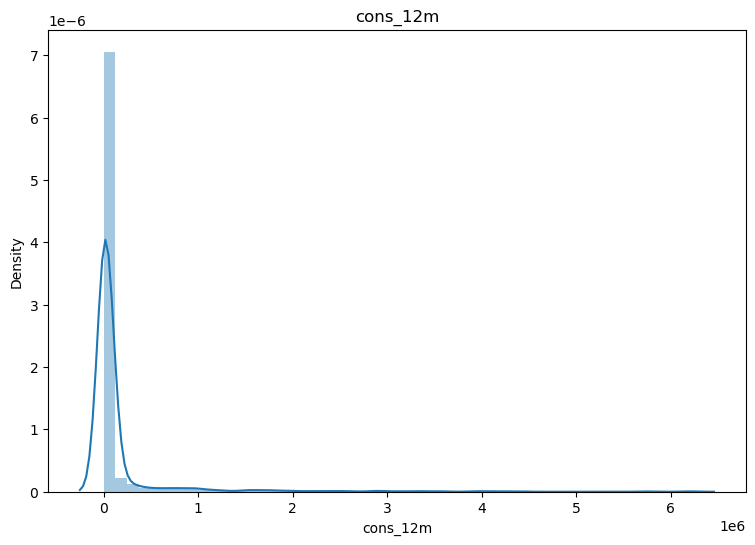

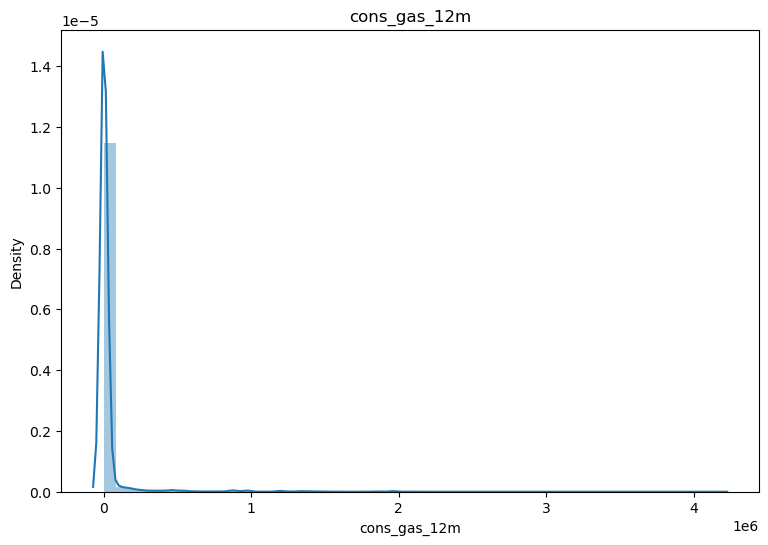

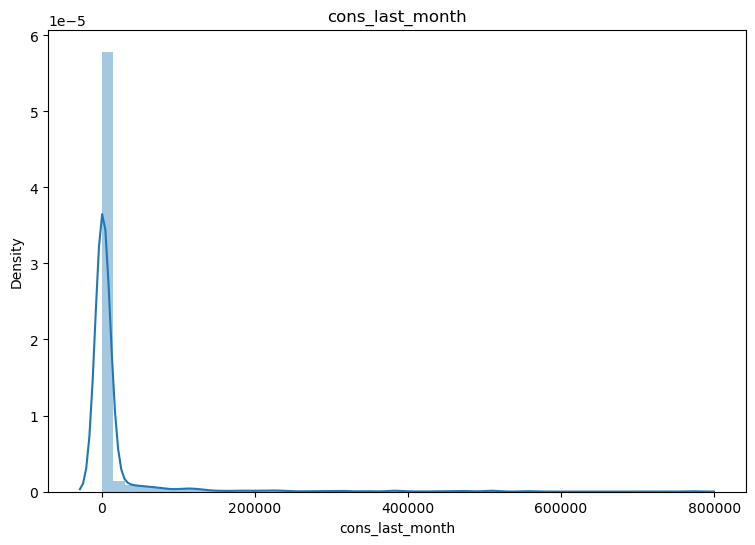

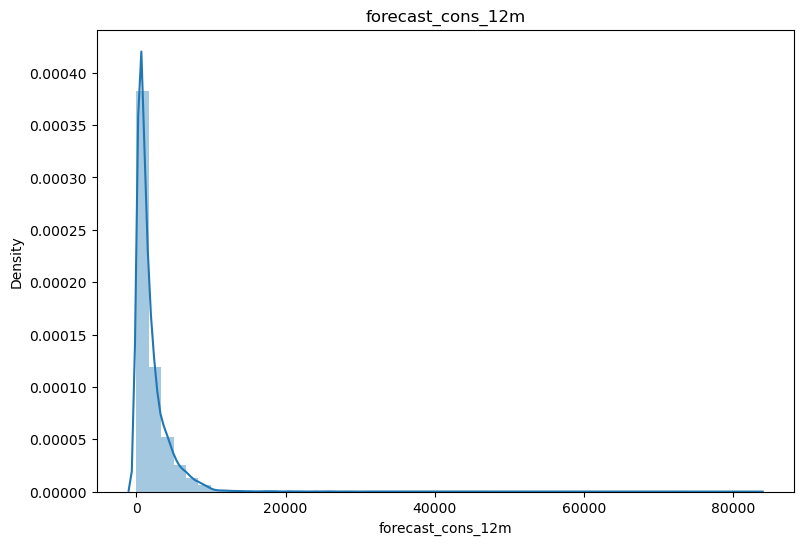

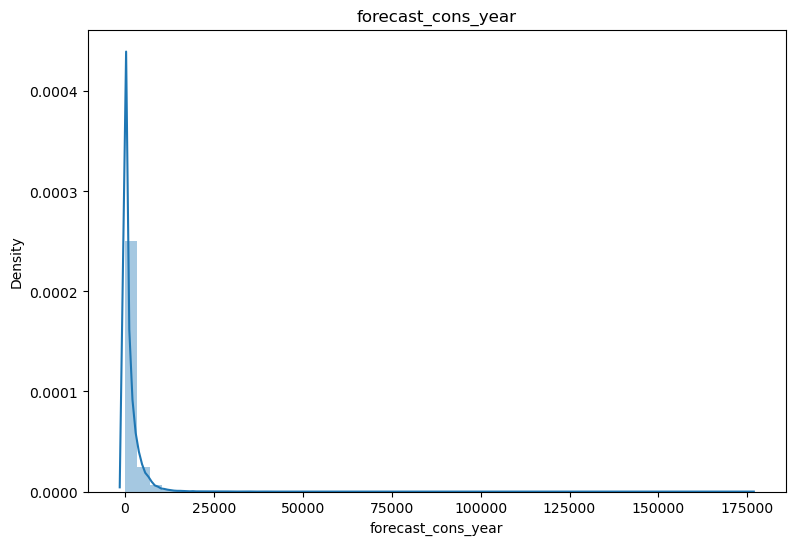

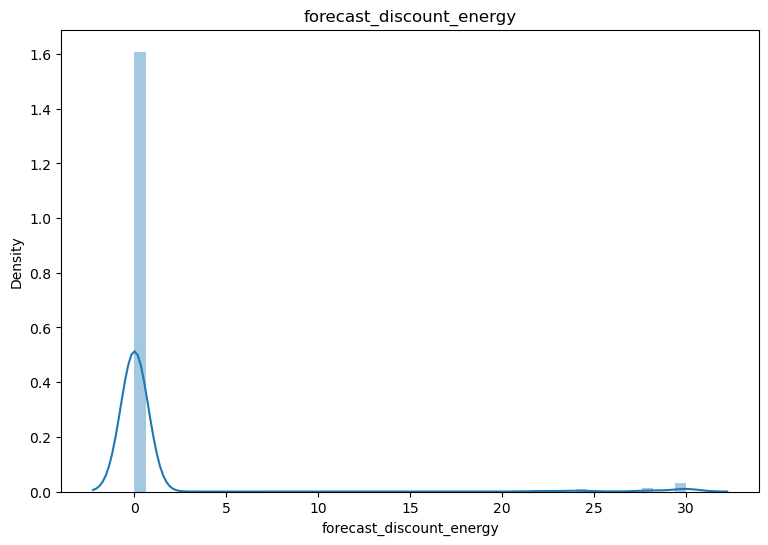

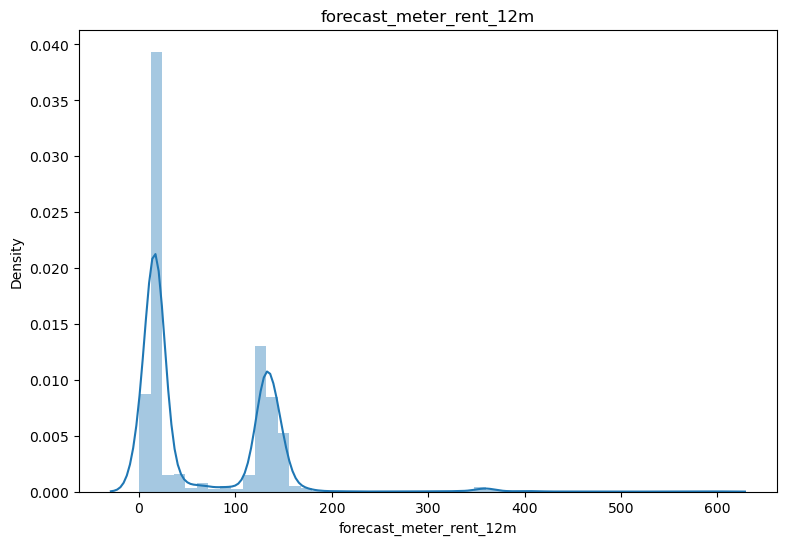

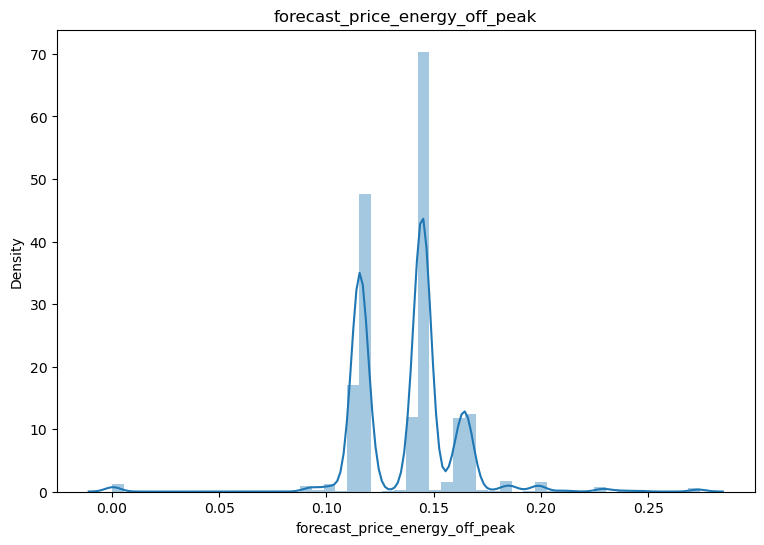

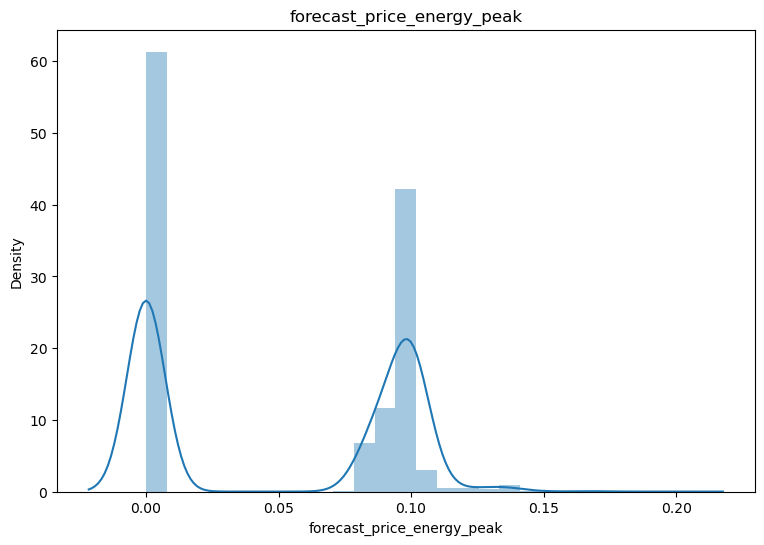

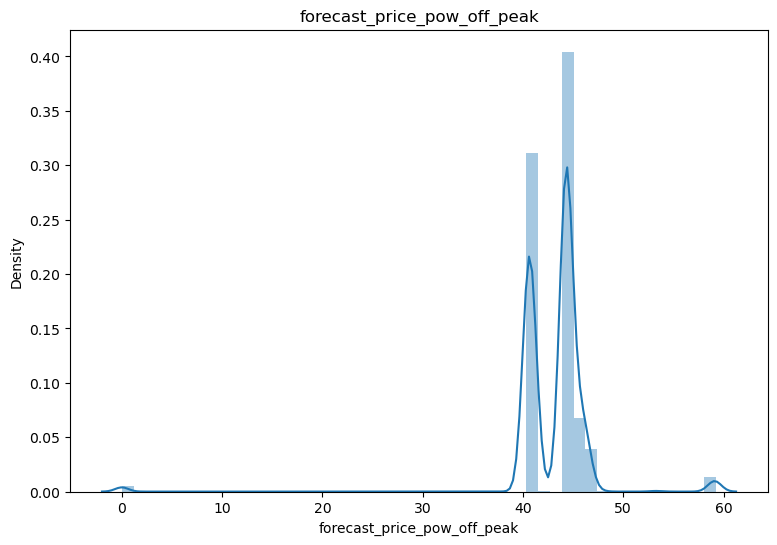

In [20]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax)
    ax.set_title(col)
plt.show()

We can see that the standard deviation for most of these features is quite high. Note that we cannot apply log to a value of 0, so we will add a constant of 1 to all the values. 

In [21]:
for i in numeric_features:
    df[i]=df[i].apply(lambda x:np.log(1+x))

Let's quickly check the distributions after log transformation. 

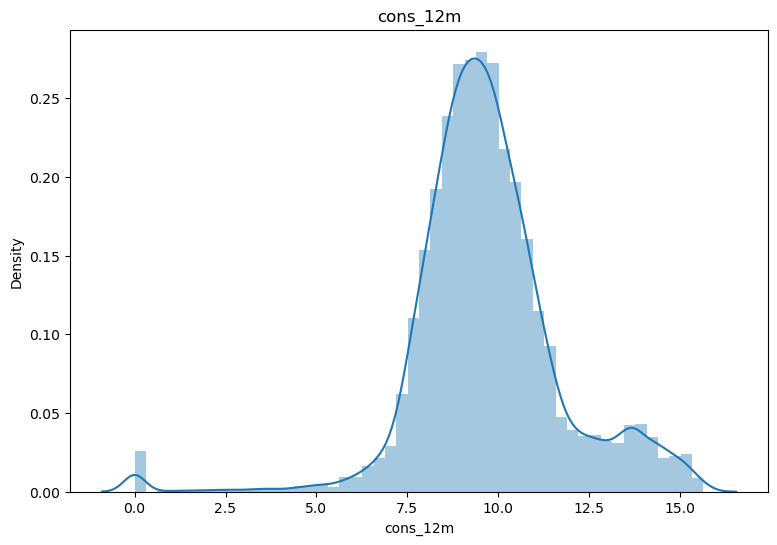

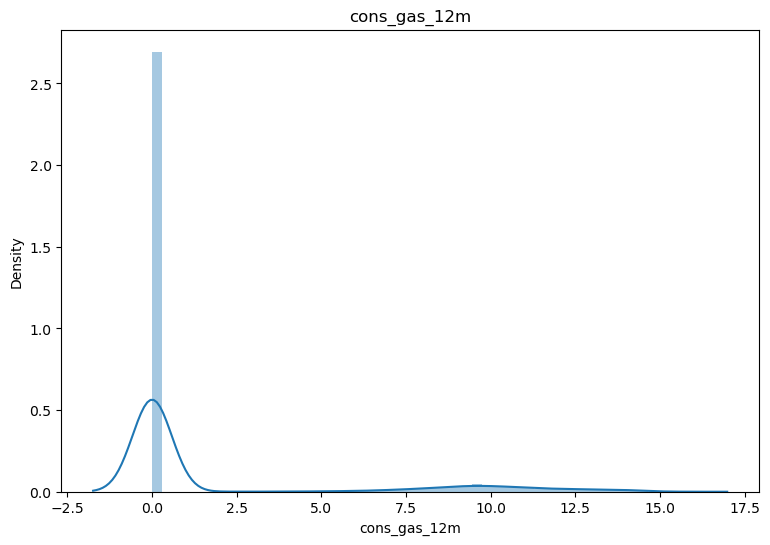

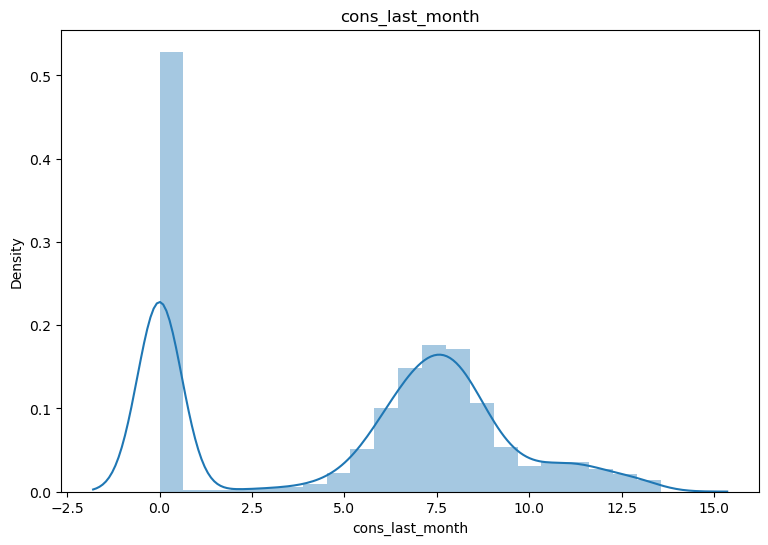

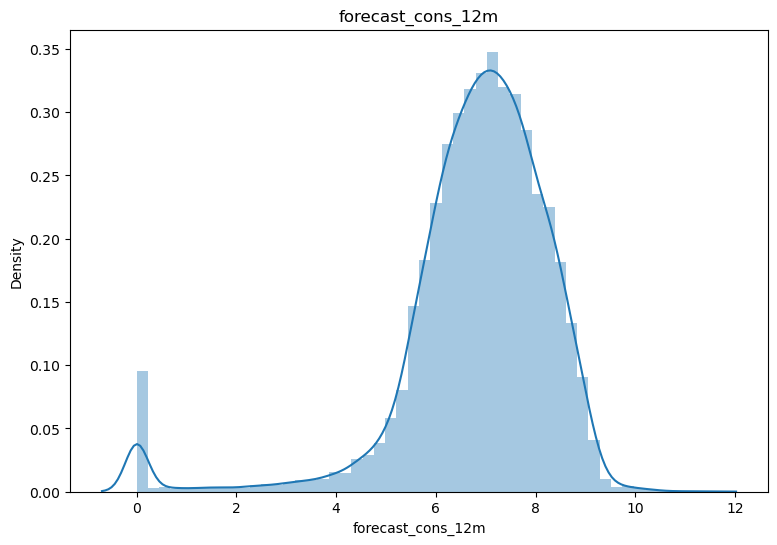

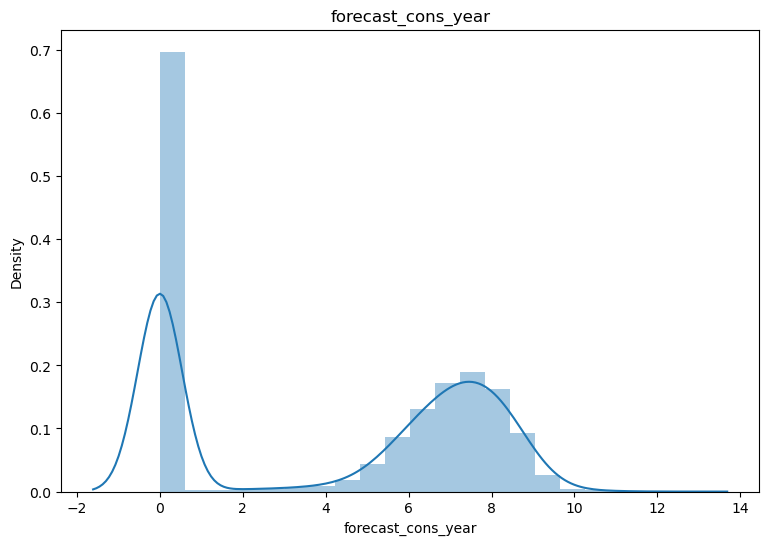

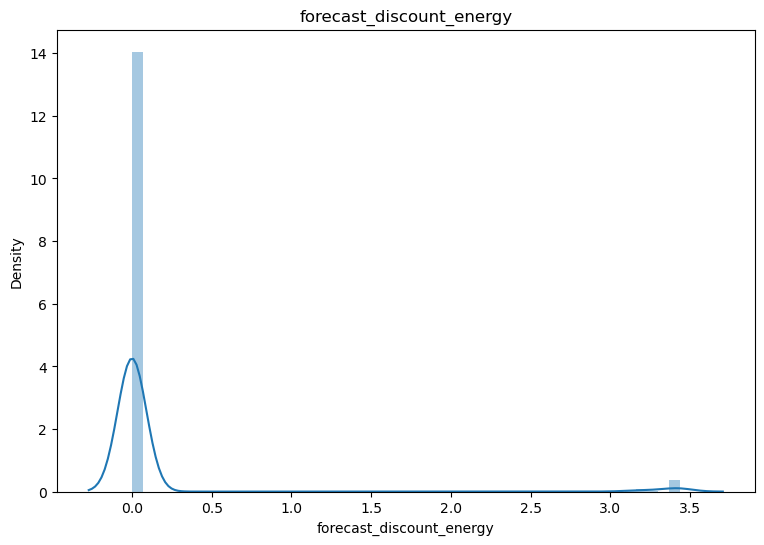

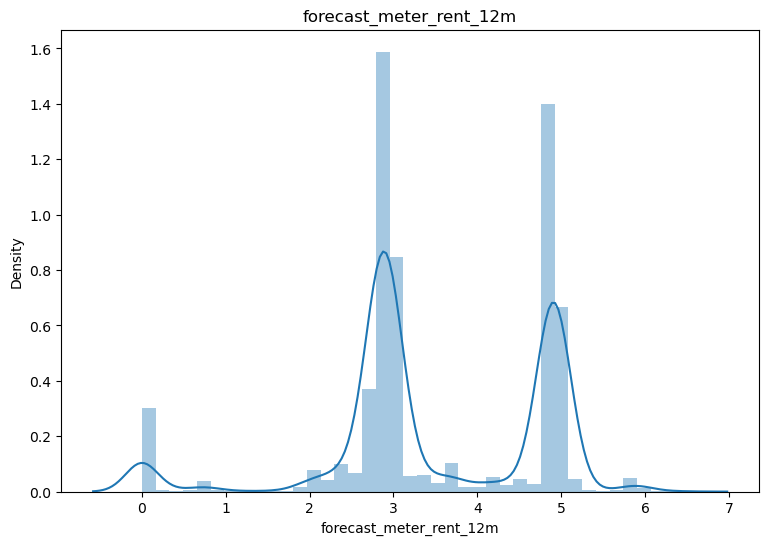

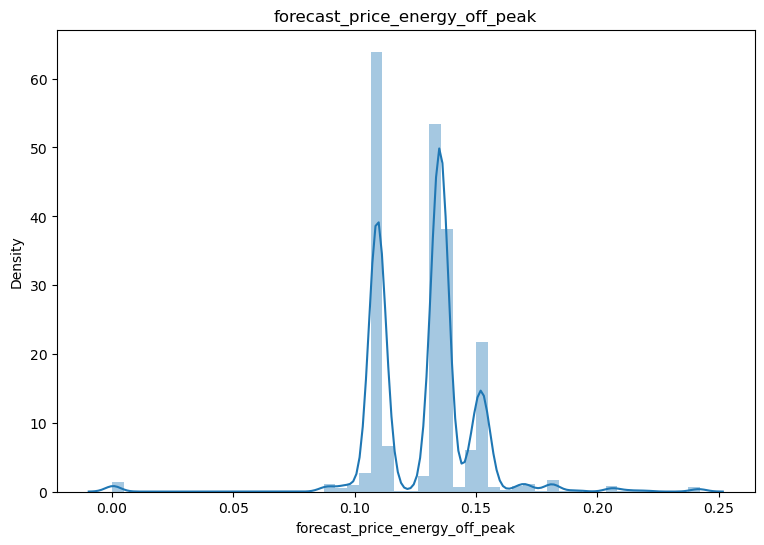

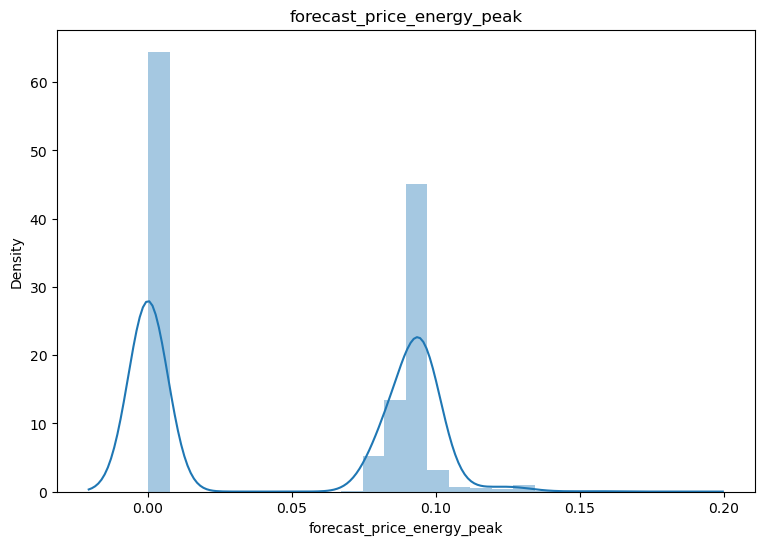

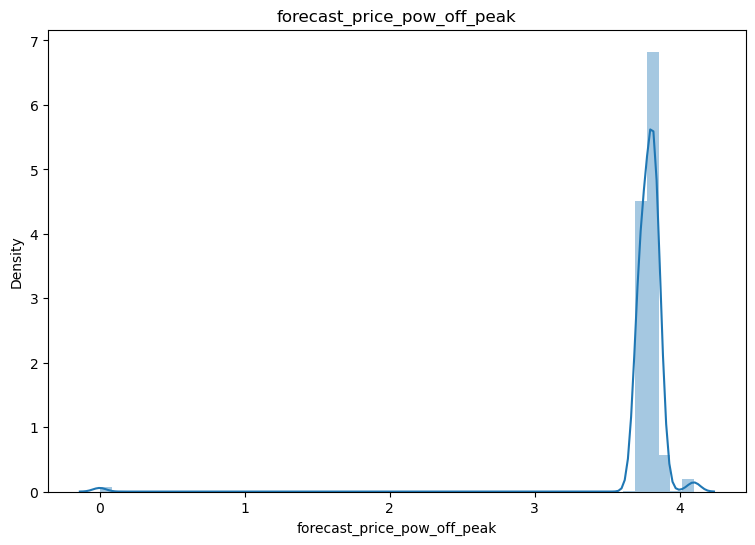

In [22]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax)
    ax.set_title(col)
plt.show()

### Correlations

In [23]:
correlation = df.corr()

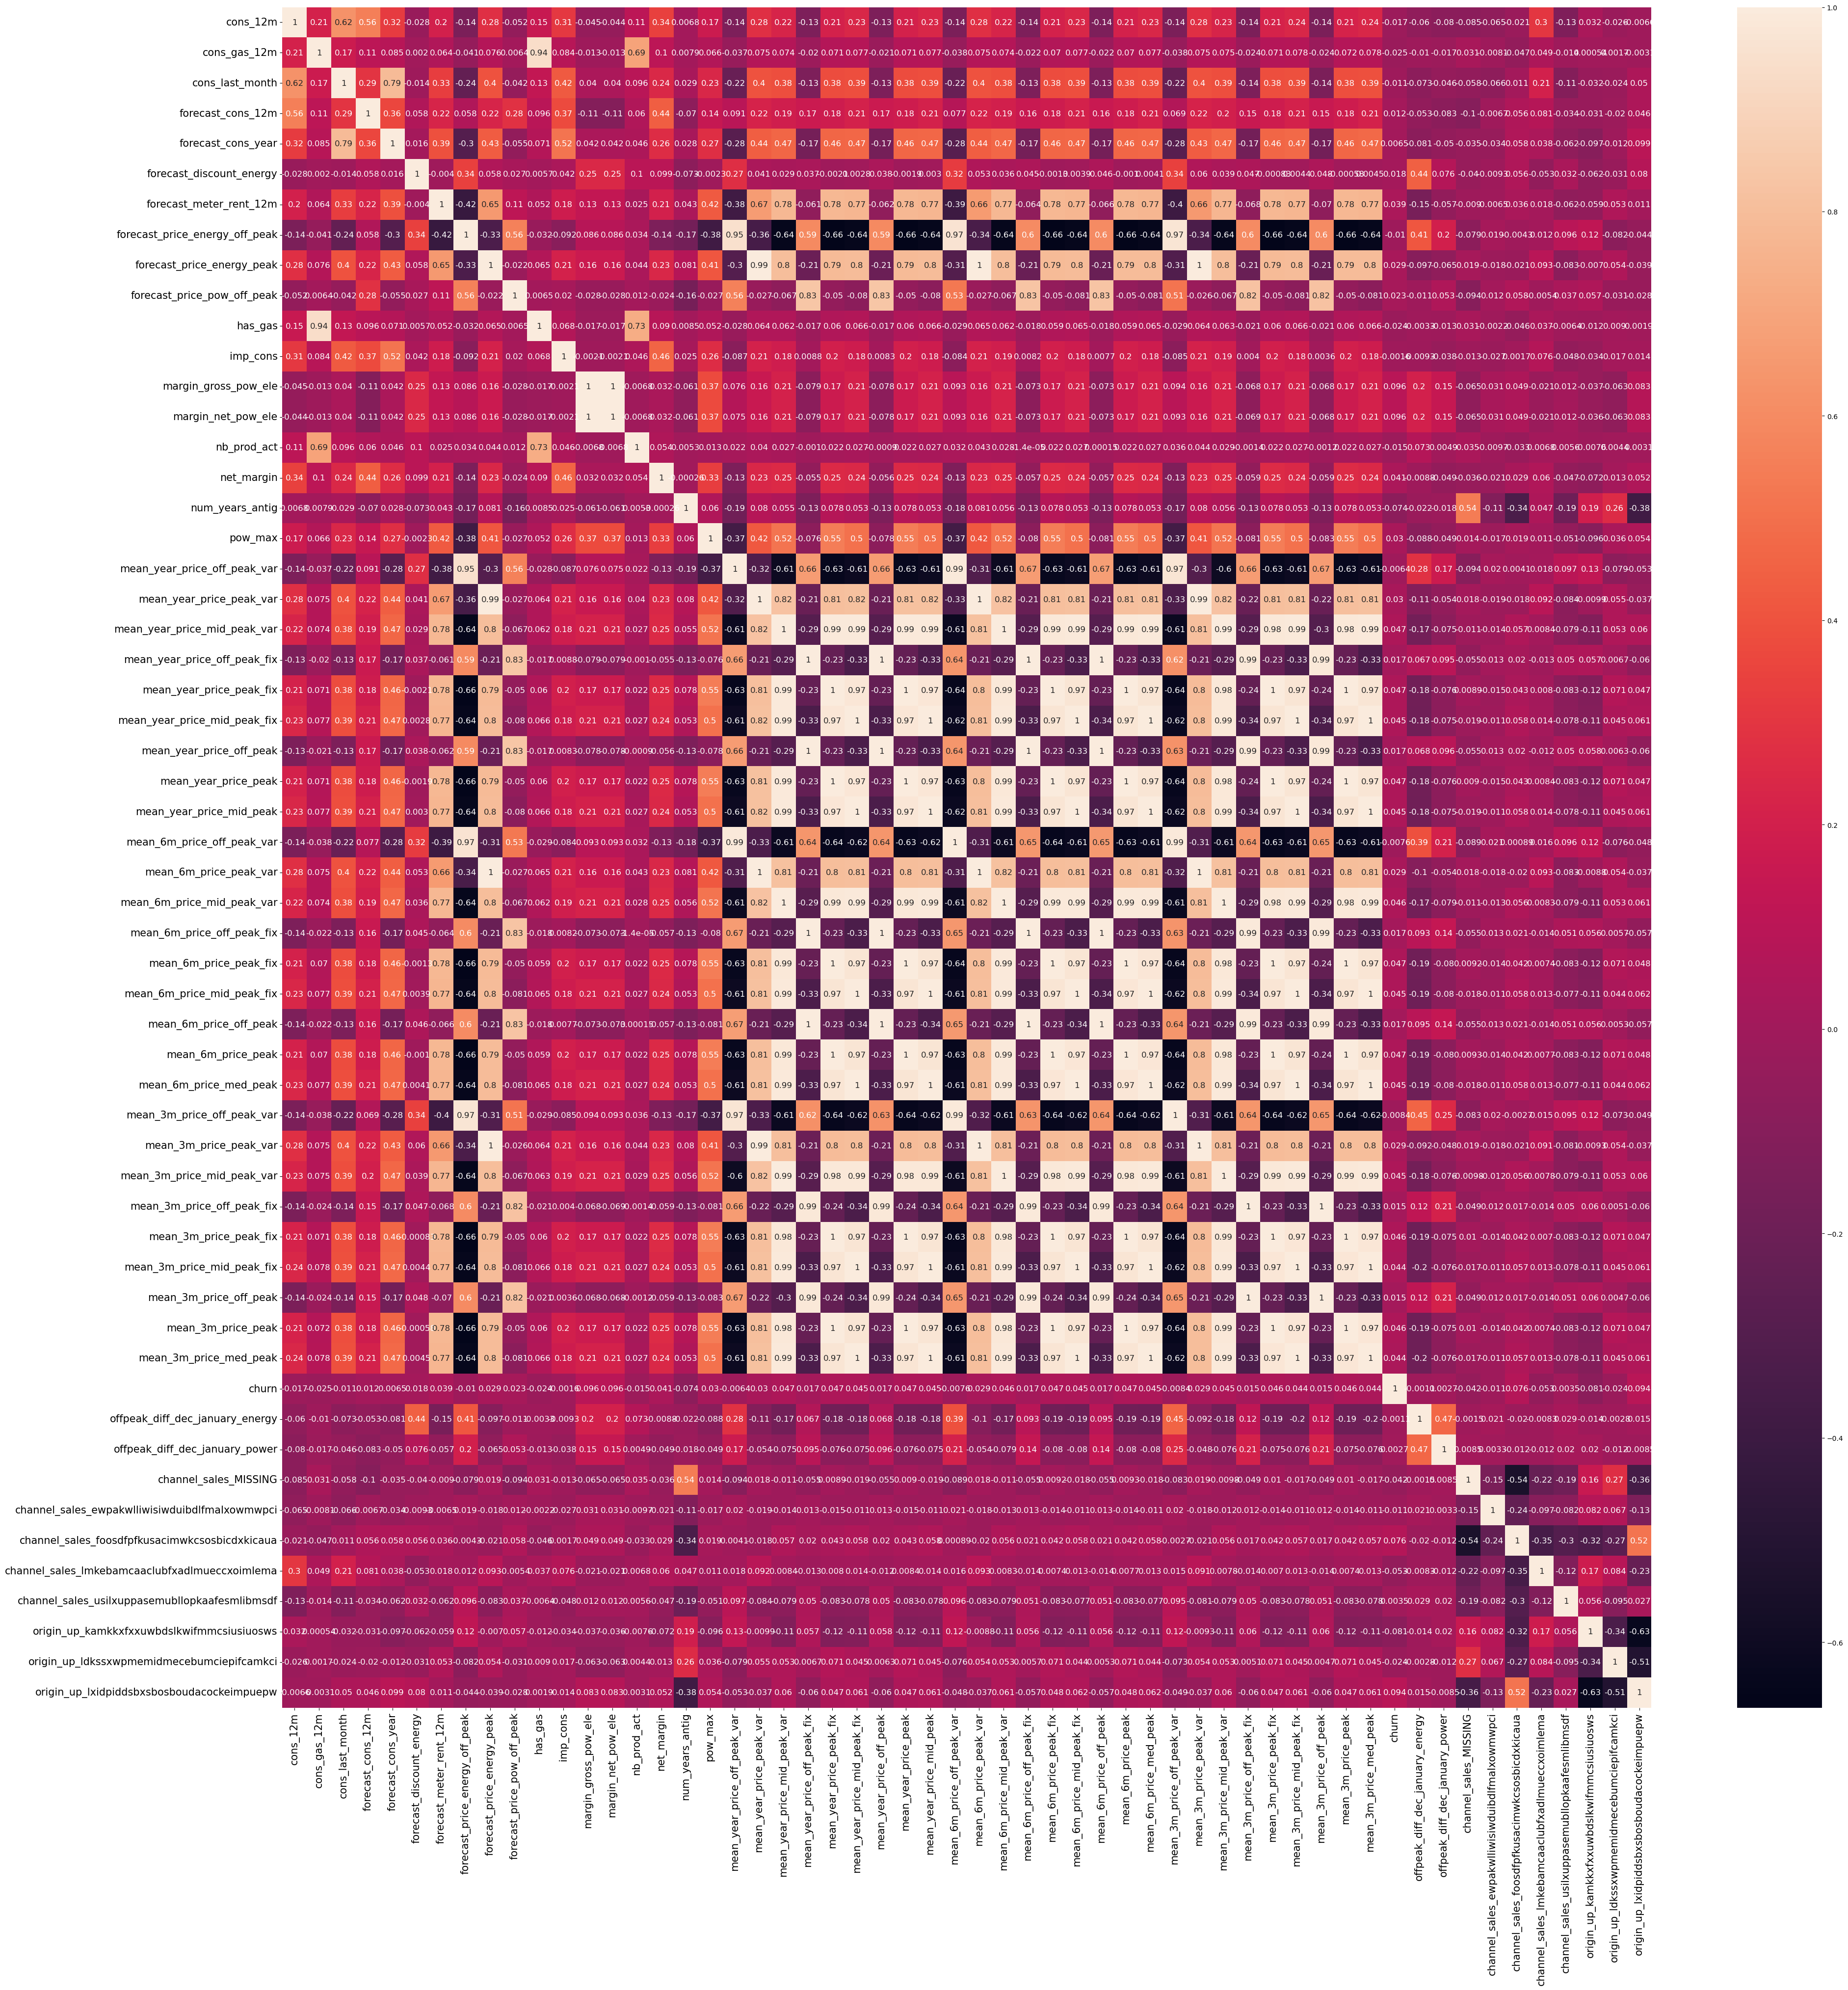

In [24]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

 I will remove some variables which exhibit a high correlation with other independent features.

In [25]:
df = df.drop(columns=['mean_year_price_mid_peak_var', 'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix', 
                      'mean_year_price_peak', 'mean_year_price_mid_peak', 'mean_6m_price_mid_peak_var', 
                      'mean_6m_price_peak_fix', 'mean_6m_price_mid_peak_fix', 'mean_6m_price_peak',
                      'mean_6m_price_med_peak', 'mean_3m_price_mid_peak_var', 'mean_3m_price_off_peak_fix', 
                      'mean_3m_price_peak_fix', 'mean_3m_price_mid_peak_fix', 'mean_3m_price_peak', 'mean_3m_price_med_peak'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.022451,0.108389,0.093620,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,2.848971,0.136025,0.000000,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,3.681855,0.153402,0.084248,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,3.036394,0.136883,0.000000,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,4.888317,0.110557,0.095324,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


## Building Prediction Models

### Split the Data 

We need to split the dataset into training dataset and testing dataset. We will use train_test_slit from sklearn package to split the data into 70% for training and hold back 30% for testing.

In [26]:
# Separate target variable from independent variables
X = df.drop(columns=['id', 'churn'])
y = df['churn']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 10223
Test cases: 4382


In [28]:
y.value_counts()

0    13186
1     1419
Name: churn, dtype: int64

We can see that the number of churn and not churn is imbalanced. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique to solve the this problem

In [29]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE().fit_resample(X, y)

In [30]:
#check the number of target variable after oversampling using SMOTE
from collections import Counter
print('Resample dataset shape', Counter(y))

Resample dataset shape Counter({1: 13186, 0: 13186})


It can be seen that the distrubtion of Churn status are now balanced.

In [31]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10223, 39)
(10223,)
(4382, 39)
(4382,)


In [32]:
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

### Random Forest 

In [33]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 1000).fit(X_train, (y_train))
print (model_RF)

RandomForestClassifier(n_estimators=1000)


True positives: 22
False positives: 7
True negatives: 3982
False negatives: 371

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3989
           1       0.76      0.06      0.10       393

    accuracy                           0.91      4382
   macro avg       0.84      0.53      0.53      4382
weighted avg       0.90      0.91      0.88      4382

Accuracy: 0.9137380191693291
Overall Precision: 0.7586206896551724
Overall Recall: 0.05597964376590331

AUC: 0.6779639555852386


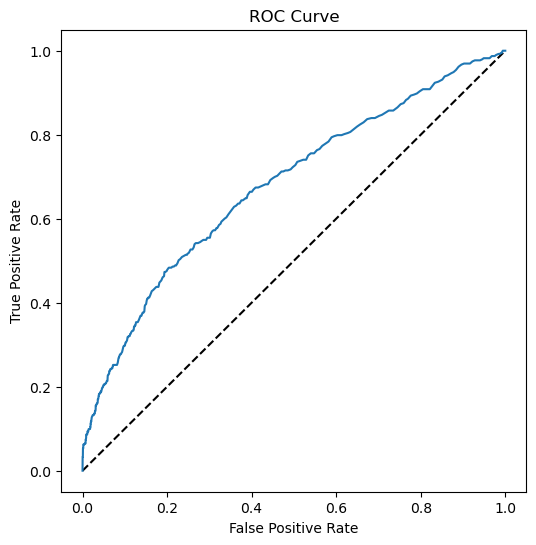

In [34]:
y_pred_RF = model_RF.predict(X_test)
y_scores_RF = model_RF.predict_proba(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RF).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(classification_report(y_test, y_pred_RF))

print('Accuracy:', accuracy_score(y_test, y_pred_RF))
print("Overall Precision:",precision_score(y_test, y_pred_RF))
print("Overall Recall:",recall_score(y_test, y_pred_RF))
auc = roc_auc_score(y_test,y_scores_RF[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_RF[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Model Understanding

Feature importances indicate the importance of a feature within the predictive model. 

In [35]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

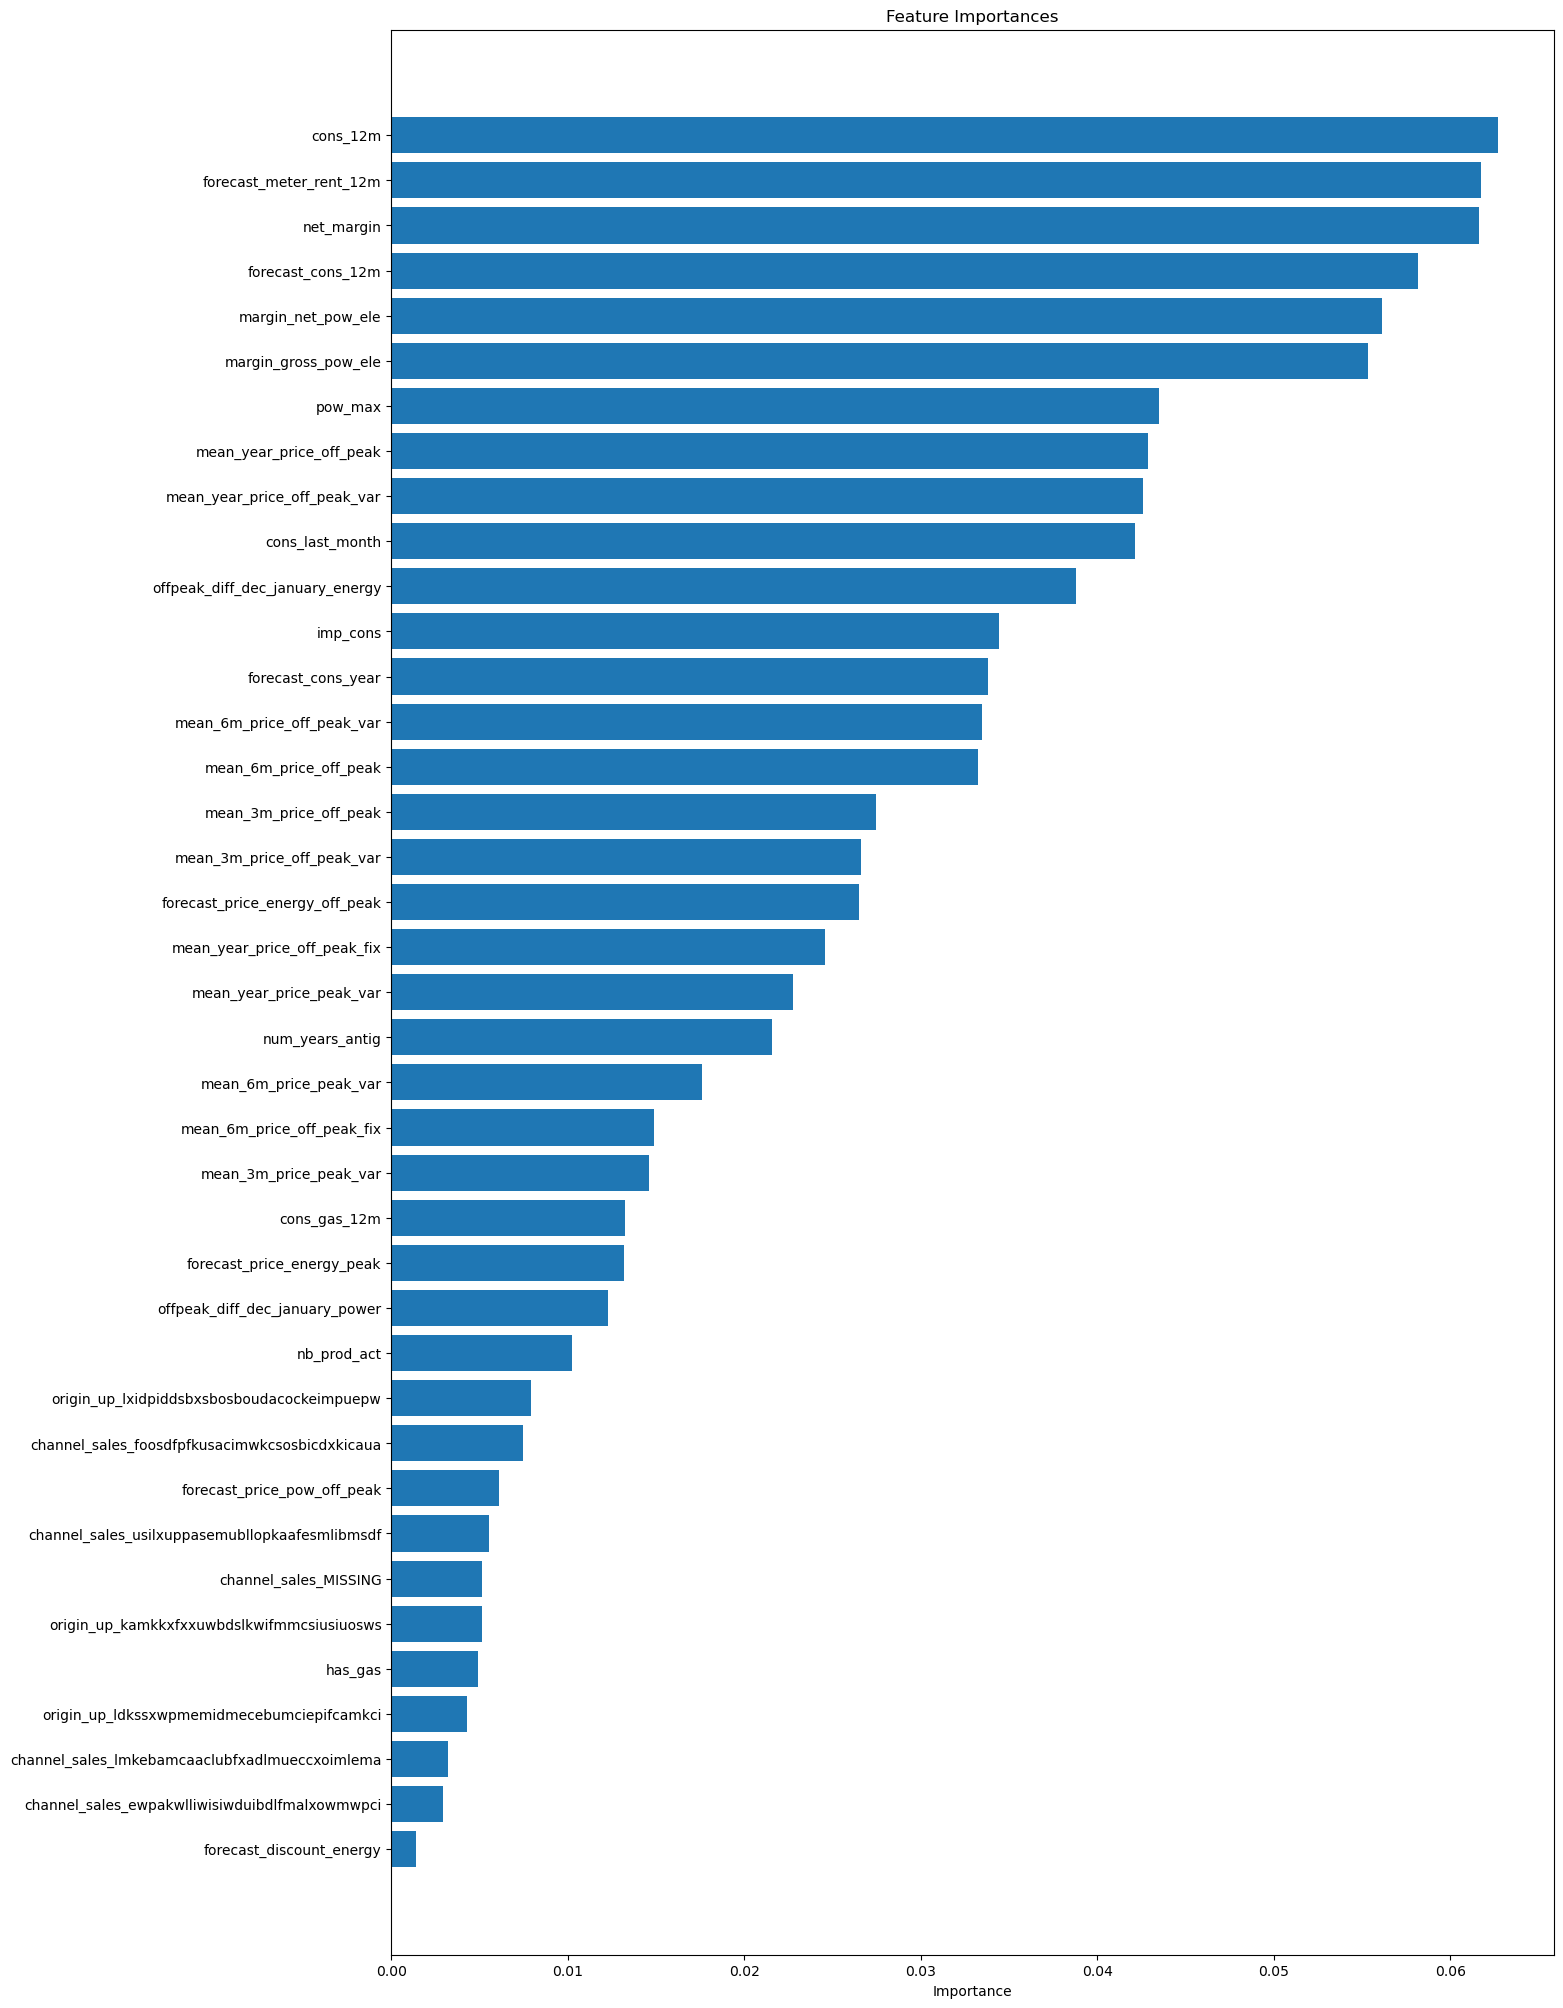

In [36]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()


From this chart, we can observe the following points:

Consumption over 12 months and forecast meter rent 12 month are a top driver for churn in this model.

Net margin also plays an important role in the predictive model. 

Our price sensitivity features are scattered around but are not the main driver for a customer churning.

In [37]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [38]:
y_scores = model_RF.predict_proba(X_test)
probabilities = y_scores[:, 1]

In [39]:
X_test['churn'] = y_pred_RF.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('data_with_predictions.csv')

Now let's save our trained model so we can use it again later.

In [40]:
import joblib
# Save the model
filename = 'powerco_churn_model.pkl'
joblib.dump(model_RF, filename)

['powerco_churn_model.pkl']